In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

In [43]:
##########################################
# This block is a literal translation of #
# src/math.ts                            #
##########################################

# Computes the price at a specific reserve `R`
def getPriceR(R, V0, k):
    return (k * R ** ((k - 1) / k)) / V0 ** (1 / k)

# Compute slippage at a point `R`, given a `deltaR`
def getSlippage(R, deltaR, V0, k):
    S = (V0 * R) ** (1 / k)
    deltaS = (V0 * (R + deltaR)) ** (1 / k) - S
    realizedPrice = deltaR / deltaS
    spotPrice = getPriceR(R, V0, k)
    return abs(realizedPrice - spotPrice) / spotPrice

# Get deltaR for a given price growth factor
def getDeltaR_priceGrowth(R, k, priceGrowth):
    return -R + (priceGrowth * R ** (1 - 1 / k)) ** (k / (-1 + k))

# Computes a tx distribution using a normal distribution,
# Given a sum of tx value and a number of transactions
# Demo: https://codepen.io/anon/pen/mNqJjv?editors=0010#0
def getTxDistribution(_sum, num):
    mean = _sum / num
    off = mean * 4
    x = []
    for i in range(0, int(num)):
        x.append(randn_bm(mean - off, mean + off))
    return x

# Random variable uniformly distributed
def rv_U(min, max):
    return random.random() * (max - min) + min


# Standard Normal variate using Box-Muller transform.
# by https://stackoverflow.com/questions/25582882/javascript-math-random-normal-distribution-gaussian-bell-curve/36481059#36481059
def randn_bm(min, max):
    u = 0
    v = 0
    while (u == 0):
        u = random.random() # Converting [0,1) to (0,1)
    while (v == 0):
        v = random.random()
    num = math.sqrt(-2.0 * math.log(u)) * math.cos(2.0 * math.pi * v)
    
    num = num / 10.0 + 0.5; # Translate to 0 -> 1
    if (num > 1) or (num < 0):
        num = randn_bm(min, max) # resample between 0 and 1 if out of range
    num *= max - min # Stretch to fill range
    num += min # offset to min
    return num


In [46]:
##########################################
# This block represent the user choices  #
# src/App.ts                             #
##########################################

# Given data
d0 = 1e6
theta = 0.35
p0 = 0.1
p1 = 0.3
wFee = 0.05

# Initial params
k = p1 / p0 / (1 - theta)
R0 = (1 - theta) * d0
S0 = d0 / p0
V0 = S0 ** k / R0

In [49]:
##########################################
# Literal translation of the price walk  #
# in src/App.ts                          #
##########################################

# Price walk
R_t = [R0]
p_t = [getPriceR(R0, V0, k)]
wFee_t = [0]
slippage_t = []
avgTxSize_t = []

numSteps = 52

for t in range(0, numSteps):
    txsWeek = rv_U(5, 2 * t + 5)
    priceGrowth = rv_U(0.99, 1.03)

    R = R_t[-1]
    deltaR = getDeltaR_priceGrowth(R, k, priceGrowth)

    R_next = R + deltaR
    txs = getTxDistribution(deltaR, txsWeek)
    # Compute slippage
    slippage_txs = [getSlippage(R, txR, V0, k) for txR in txs]
    slippage = np.mean(slippage_txs)
    
    txsWithdraw = filter(lambda tx: tx < 0, txs)
    wFees = -wFee * sum(txsWithdraw)

    # Store variables
    R_t.append(R_next)
    p_t.append(getPriceR(R_next, V0, k))
    slippage_t.append(slippage)
    wFee_t.append(wFees)

Text(0, 0.5, 'Price')

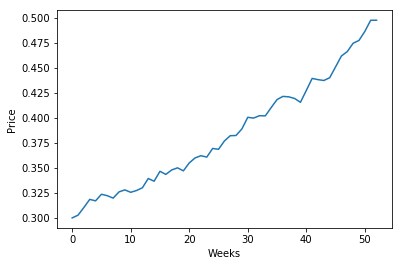

In [56]:
##########################################
# Same graph as the one showed after     #
# clicking "Run simulation"              #
##########################################

plt.plot(p_t)
plt.xlabel('Weeks')
plt.ylabel('Price')